In [1]:
from HARK.utilities import plot_funcs
from time import process_time
from copy import deepcopy, copy
import numpy as np
from HARK.ConsumptionSaving.ConsIndShockModel import init_idiosyncratic_shocks
from HARK.ConsumptionSaving.ConsMarkovModel import MarkovConsumerType
from HARK.distribution import DiscreteDistribution
mystr = lambda number: "{:.4f}".format(number)
do_simulation = True

This module defines consumption-saving models in which an agent has CRRA utility over consumption, geometrically discounts future utility flows and expects to experience transitory and permanent shocks to his/her income. Moreover, in any given period s/he is in exactly one of several discrete states. This state evolves from period to period according to a Markov process.

In this model, an agent is very similar to the one in the "idiosyncratic shocks" model of $\texttt{ConsPrefShockModel}$, except that here, an agent's income distribution ($F_{\psi t},F_{\theta t}$), permanent income growth rate $\Gamma_{t+1}$ and interest factor $R$ are all functions of the Markov state and might vary across states.

The agent's problem can be written in Bellman form as:

\begin{eqnarray*}
v_t(m_t,s_t) &=& \max_{c_t} u(c_t) + \beta (1-\mathsf{D}_{t+1}) \mathbb{E} [v_{t+1}(m_{t+1}, s_{t+1}) ], \\
a_t &=& m_t - c_t, \\
a_t &\geq& \underline{a}, \\
m_{t+1} &=& \frac{R(s_{t+1})}{\Gamma(s_{t+1})\psi_{t+1}} a_t + \theta_{t+1}, \\
\theta_{t} \sim F_{\theta t}(s_t), &\qquad& \psi_{t} \sim F_{\psi t}(s_t), \mathbb{E} [F_{\psi t}(s_t)] = 1, \\
Prob[s_{t+1}=j| s_t=i] &=& \triangle_{ij}, \\
u(c) &=& \frac{c^{1-\rho}}{1-\rho}
\end{eqnarray*}

The Markov matrix $\triangle$ is giving transition probabilities from current state $i$ to future state $j$. 

The one period problem for this model is solved by the function $\texttt{solveConsMarkov}$, which creates an instance of the class $\texttt{ConsMarkovSolver}$. The class $\texttt{MarkovConsumerType}$ extends $\texttt{IndShockConsumerType}$ to represents agents in this model.

To construct an instance of this class, the same attributes as for $\texttt{IndShockConsumerType}$ are required, except for one as described below:

### Additional parameter value to solve an instance of MarkovConsumerType

| Param | Description | Code | Value | Constructed |
| :---: | --- | --- | --- | :---: |
| $\triangle$ |Discrete state transition probability matrix  | $\texttt{MrkvArray}$ |  |$\surd$ |

The attribute $\texttt{MrkvArray}$ is a $\texttt{numpy.array}$ of size ($N_s$, $N_s$) corresponding to the number of discrete states. 

Note that $\texttt{MrkvArray}$ is am element of $\texttt{time_inv}$, so that the same transition probabilities are used for each period. However, it can be moved to $\texttt{time_vary}$ and specified as a list of $\texttt{array}$s instead.

The attributes $\texttt{Rfree}$, $\texttt{PermGroFac}$ and $\texttt{IncomeDstn}$ should be specified as arrays or lists with $N_s$ elements for each period.

### Solve MarkovConsumerType

When the $\texttt{MarkovConsumerType}$ method of a $\texttt{MarkovConsumerType}$ is invoked, the $\texttt{solution}$ attribute is populated with a list of $\texttt{ConsumerSolution}$ objects, which each have the same attributes as the "idiosyncratic shocks" model. However, each attribute is now a list (or array) whose elements are *state-conditional* values of that object. 

For example, in a model with 4 discrete states, each the $\texttt{cFunc}$ attribute of each element of $\texttt{solution}$ is a length-4 list whose elements are state-conditional consumption functions. That is, $\texttt{cFunc[2]}$ is the consumption function when $s_t = 2$.

$\texttt{ConsMarkovModel}$ is compatible with cubic spline interpolation for the consumption functions, so $\texttt{CubicBool = True}$ will not generate an exception. The problem is solved using the [method of endogenous gridpoints](http://www.econ2.jhu.edu/people/ccarroll/EndogenousGridpoints.pdf), which is moderately more complicated than in the basic $\texttt{ConsPrefShockModel}$.

In [2]:
# Define the Markov transition matrix for serially correlated unemployment
unemp_length = 5  # Averange length of unemployment spell
urate_good = 0.05  # Unemployment rate when economy is in good state
urate_bad = 0.12  # Unemployment rate when economy is in bad state
bust_prob = 0.01  # Probability of economy switching from good to bad
recession_length = 20  # Averange length of bad state
p_reemploy = 1.0 / unemp_length
p_unemploy_good = p_reemploy * urate_good / (1 - urate_good)
p_unemploy_bad = p_reemploy * urate_bad / (1 - urate_bad)
boom_prob = 1.0 / recession_length
MrkvArray = np.array(
    [
        [
            (1 - p_unemploy_good) * (1 - bust_prob),
            p_unemploy_good * (1 - bust_prob),
            (1 - p_unemploy_good) * bust_prob,
            p_unemploy_good * bust_prob,
        ],
        [
            p_reemploy * (1 - bust_prob),
            (1 - p_reemploy) * (1 - bust_prob),
            p_reemploy * bust_prob,
            (1 - p_reemploy) * bust_prob,
        ],
        [
            (1 - p_unemploy_bad) * boom_prob,
            p_unemploy_bad * boom_prob,
            (1 - p_unemploy_bad) * (1 - boom_prob),
            p_unemploy_bad * (1 - boom_prob),
        ],
        [
            p_reemploy * boom_prob,
            (1 - p_reemploy) * boom_prob,
            p_reemploy * (1 - boom_prob),
            (1 - p_reemploy) * (1 - boom_prob),
        ],
    ]
)

Several variant examples of the model will be illustrated below such that:
1. Model with serially correlated unemployment
2. Model with period of "unemployment immunity"
3. Model with serially correlated permanent income growth
4. Model with serially correlated interest factor

### 1. Serial Unemployment 

Let's create a consumer similar to the one in "idiosyncratic shock" model but who faces serially correlated unemployment during boom or bust cycles of the economy.

In [3]:
# Make a consumer with serially correlated unemployment, subject to boom and bust cycles
init_serial_unemployment = copy(init_idiosyncratic_shocks)
init_serial_unemployment["MrkvArray"] = [MrkvArray]
init_serial_unemployment["UnempPrb"] = 0  # to make income distribution when employed
init_serial_unemployment["global_markov"] = False
SerialUnemploymentExample = MarkovConsumerType(**init_serial_unemployment)
SerialUnemploymentExample.cycles = 0
SerialUnemploymentExample.vFuncBool = False  # for easy toggling here

In [4]:
# Replace the default (lognormal) income distribution with a custom one
employed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.ones(1)])  # Definitely get income
unemployed_income_dist = DiscreteDistribution(np.ones(1), [np.ones(1), np.zeros(1)]) # Definitely don't
SerialUnemploymentExample.IncShkDstn = [
    [
        employed_income_dist,
        unemployed_income_dist,
        employed_income_dist,
        unemployed_income_dist,
    ]
]

Note that $\texttt{MarkovConsumerType}$ currently has no method to automatically construct a valid IncomeDstn - $\texttt{IncomeDstn}$ is manually constructed in each case. Writing a method to supersede $\texttt{IndShockConsumerType.update_income_process}$ for the “Markov model” would be a welcome contribution!

In [5]:
# Interest factor, permanent growth rates, and survival probabilities are constant arrays
SerialUnemploymentExample.assign_parameters(Rfree = np.array(4 * [SerialUnemploymentExample.Rfree]))
SerialUnemploymentExample.PermGroFac = [
    np.array(4 * SerialUnemploymentExample.PermGroFac)
]
SerialUnemploymentExample.LivPrb = [SerialUnemploymentExample.LivPrb * np.ones(4)]

Solving a Markov consumer with serially correlated unemployment took 0.2187 seconds.
Consumption functions for each discrete state:


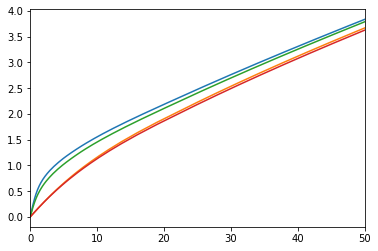

In [6]:
# Solve the serial unemployment consumer's problem and display solution
start_time = process_time()
SerialUnemploymentExample.solve()
end_time = process_time()
print(
    "Solving a Markov consumer with serially correlated unemployment took "
    + mystr(end_time - start_time)
    + " seconds."
)
print("Consumption functions for each discrete state:")
plot_funcs(SerialUnemploymentExample.solution[0].cFunc, 0, 50)
if SerialUnemploymentExample.vFuncBool:
    print("Value functions for each discrete state:")
    plot_funcs(SerialUnemploymentExample.solution[0].vFunc, 5, 50)

In [7]:
# Simulate some data; results stored in cHist, mNrm_hist, cNrm_hist, and Mrkv_hist
if do_simulation:
    SerialUnemploymentExample.T_sim = 120
    SerialUnemploymentExample.MrkvPrbsInit = [0.25, 0.25, 0.25, 0.25]
    SerialUnemploymentExample.track_vars = ["mNrm", "cNrm"]
    SerialUnemploymentExample.make_shock_history()  # This is optional
    SerialUnemploymentExample.initialize_sim()
    SerialUnemploymentExample.simulate()

### 2. Unemployment immunity for a fixed period

Let's create a consumer similar to the one in "idiosyncratic shock" model but who occasionally gets "unemployment immunity" for a fixed period in an economy subject to boom and bust cycles.

In [8]:
# Make a consumer who occasionally gets "unemployment immunity" for a fixed period
UnempPrb = 0.05  # Probability of becoming unemployed each period
ImmunityPrb = 0.01  # Probability of becoming "immune" to unemployment
ImmunityT = 6  # Number of periods of immunity

In [9]:
StateCount = ImmunityT + 1  # Total number of Markov states
IncomeDstnReg = DiscreteDistribution(
    np.array([1 - UnempPrb, UnempPrb]),
    [np.array([1.0, 1.0]),
     np.array([1.0 / (1.0 - UnempPrb), 0.0])]
)  # Ordinary income distribution
IncomeDstnImm = DiscreteDistribution(
    np.array([1.0]),
    [np.array([1.0]),
     np.array([1.0])]
)
IncomeDstn = [IncomeDstnReg] + ImmunityT * [
    IncomeDstnImm
]  # Income distribution for each Markov state, in a list

In [10]:
# Make the Markov transition array.  MrkvArray[i,j] is the probability of transitioning
# to state j in period t+1 from state i in period t.
MrkvArray = np.zeros((StateCount, StateCount))
MrkvArray[0, 0] = (
    1.0 - ImmunityPrb
)  # Probability of not becoming immune in ordinary state: stay in ordinary state
MrkvArray[
    0, ImmunityT
] = (
    ImmunityPrb
)  # Probability of becoming immune in ordinary state: begin immunity periods
for j in range(ImmunityT):
    MrkvArray[
        j + 1, j
    ] = (
        1.0
    )  # When immune, have 100% chance of transition to state with one fewer immunity periods remaining

In [11]:
init_unemployment_immunity = copy(init_idiosyncratic_shocks)
init_unemployment_immunity["MrkvArray"] = [MrkvArray]
ImmunityExample = MarkovConsumerType(**init_unemployment_immunity)
ImmunityExample.assign_parameters(
    Rfree=np.array(np.array(StateCount * [1.03])),  # Interest factor same in all states
    PermGroFac=[
        np.array(StateCount * [1.01])
    ],  # Permanent growth factor same in all states
    LivPrb=[np.array(StateCount * [0.98])],  # Same survival probability in all states
    BoroCnstArt=None,  # No artificial borrowing constraint
    cycles=0,
)  # Infinite horizon
ImmunityExample.IncShkDstn = [IncomeDstn]

Solving an "unemployment immunity" consumer took 0.3605 seconds.
Consumption functions for each discrete state:


/home/sb/projects/econ-ark/HARK/HARK/interpolation.py:2027: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)
/home/sb/projects/econ-ark/HARK/HARK/interpolation.py:2027: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)
/home/sb/projects/econ-ark/HARK/HARK/interpolation.py:2027: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)
/home/sb/projects/econ-ark/HARK/HARK/interpolation.py:2027: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)
/home/sb/projects/econ-ark/HARK/HARK/interpolation.py:2027: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)
/home/sb/projects/econ-ark/HARK/HARK/interpolation.py:2027: RuntimeWarning: All-NaN slice encountered
  y = self.compare(fx, axis=1)


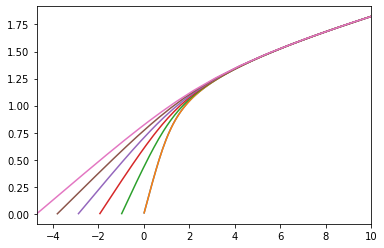

In [12]:
# Solve the unemployment immunity problem and display the consumption functions
start_time = process_time()
ImmunityExample.solve()
end_time = process_time()
print(
    'Solving an "unemployment immunity" consumer took '
    + mystr(end_time - start_time)
    + " seconds."
)
print("Consumption functions for each discrete state:")
mNrmMin = np.min([ImmunityExample.solution[0].mNrmMin[j] for j in range(StateCount)])
plot_funcs(ImmunityExample.solution[0].cFunc, mNrmMin, 10)

### 3. Serial permanent income growth

Let's create a consumer similar to the one in "idiosyncratic shock" model but who faces serially correlated permanent income growth in an economy subject to boom and bust cycles.

In [13]:
# Make a consumer with serially correlated permanent income growth
UnempPrb = 0.05  # Unemployment probability
StateCount = 5  # Number of permanent income growth rates
Persistence = (
    0.5
)  # Probability of getting the same permanent income growth rate next period

In [14]:
IncomeDstnReg = DiscreteDistribution(
    np.array([1 - UnempPrb, UnempPrb]),
    [np.array([1.0, 1.0]),
     np.array([1.0, 0.0])]
)
IncomeDstn = StateCount * [
    IncomeDstnReg
]  # Same simple income distribution in each state

In [15]:
# Make the state transition array for this type: Persistence probability of remaining in the same state, equiprobable otherwise
MrkvArray = Persistence * np.eye(StateCount) + (1.0 / StateCount) * (
    1.0 - Persistence
) * np.ones((StateCount, StateCount))

In [18]:
init_serial_growth = copy(init_idiosyncratic_shocks)
init_serial_growth["MrkvArray"] = [MrkvArray]
SerialGroExample = MarkovConsumerType(**init_serial_growth)
SerialGroExample.assign_parameters(
    Rfree=np.array(
        np.array(StateCount * [1.03])
    ),  # Same interest factor in each Markov state
    PermGroFac=[
        np.array([0.97, 0.99, 1.01, 1.03, 1.05])
    ],  # Different permanent growth factor in each Markov state
    LivPrb=[np.array(StateCount * [0.98])],  # Same survival probability in all states
    cycles=0,
)
SerialGroExample.IncShkDstn = [IncomeDstn]

### 4. Serial Interest factor

Finally, suppose that the consumer faces a interest factor serially correlated while his/her permanent income growth rate is constant. 

Solving a serially correlated growth consumer took 0.3749 seconds.
Consumption functions for each discrete state:


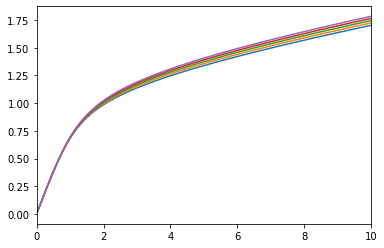

In [19]:
# Solve the serially correlated permanent growth shock problem and display the consumption functions
start_time = process_time()
SerialGroExample.solve()
end_time = process_time()
print(
    "Solving a serially correlated growth consumer took "
    + mystr(end_time - start_time)
    + " seconds."
)
print("Consumption functions for each discrete state:")
plot_funcs(SerialGroExample.solution[0].cFunc, 0, 10)

In [20]:
# Make a consumer with serially correlated interest factors
SerialRExample = deepcopy(SerialGroExample)  # Same as the last problem...
SerialRExample.assign_parameters(
    PermGroFac=[
        np.array(StateCount * [1.01])
    ],  # ...but now the permanent growth factor is constant...
    Rfree=np.array([1.01, 1.02, 1.03, 1.04, 1.05]),
)  # ...and the interest factor is what varies across states

Solving a serially correlated interest consumer took 0.4514 seconds.
Consumption functions for each discrete state:


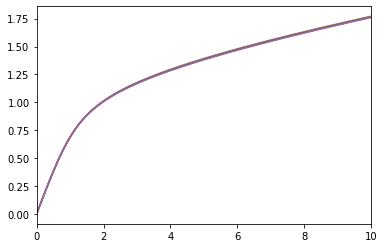

In [21]:
# Solve the serially correlated interest rate problem and display the consumption functions
start_time = process_time()
SerialRExample.solve()
end_time = process_time()
print(
    "Solving a serially correlated interest consumer took "
    + mystr(end_time - start_time)
    + " seconds."
)
print("Consumption functions for each discrete state:")
plot_funcs(SerialRExample.solution[0].cFunc, 0, 10)